In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle competitions download -c dog-breed-identification

 98% 676M/691M [00:03<00:00, 236MB/s]
100% 691M/691M [00:03<00:00, 197MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dog-breed-identification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [9]:
# importing required libraries, modules and pretrained model

import os
import tensorflow as tf

from tensorflow import keras
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception

SEED = 42
SIZE = (224, 224)
BATCH_SIZE = 32

pd.set_option('display.max_rows', None)

In [10]:
# training and validation data

labels = pd.read_csv('/content/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
labels['id'] = labels['id'].apply(lambda x: x + '.jpg' )
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


<Axes: xlabel='breed'>

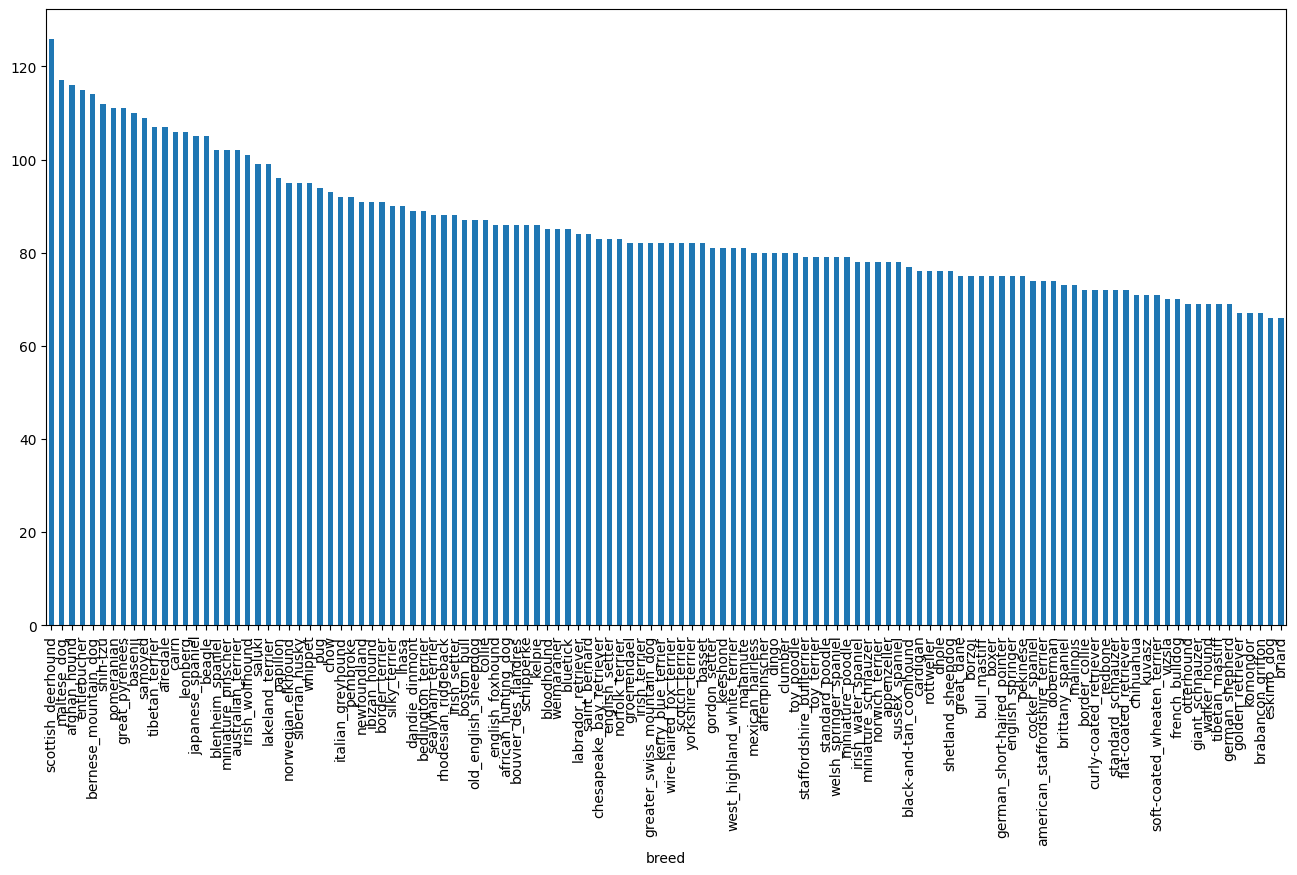

In [12]:
labels['breed'].value_counts().plot.bar(figsize=(16, 8))

In [13]:
# ImageDatagenerator to load the images in batches and perform data augmentation

data_generator = ImageDataGenerator(rescale= 1./255, validation_split=0.2, rotation_range=20,
                                    zoom_range=0.1, width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.1, horizontal_flip=True, fill_mode="nearest")

In [14]:
train_generator = data_generator.flow_from_dataframe(labels, directory='/content/train', x_col='id', y_col='breed', target_size=SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='training')
val_generator = data_generator.flow_from_dataframe(labels, directory='/content/train', x_col='id', y_col='breed', target_size=SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='validation')

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


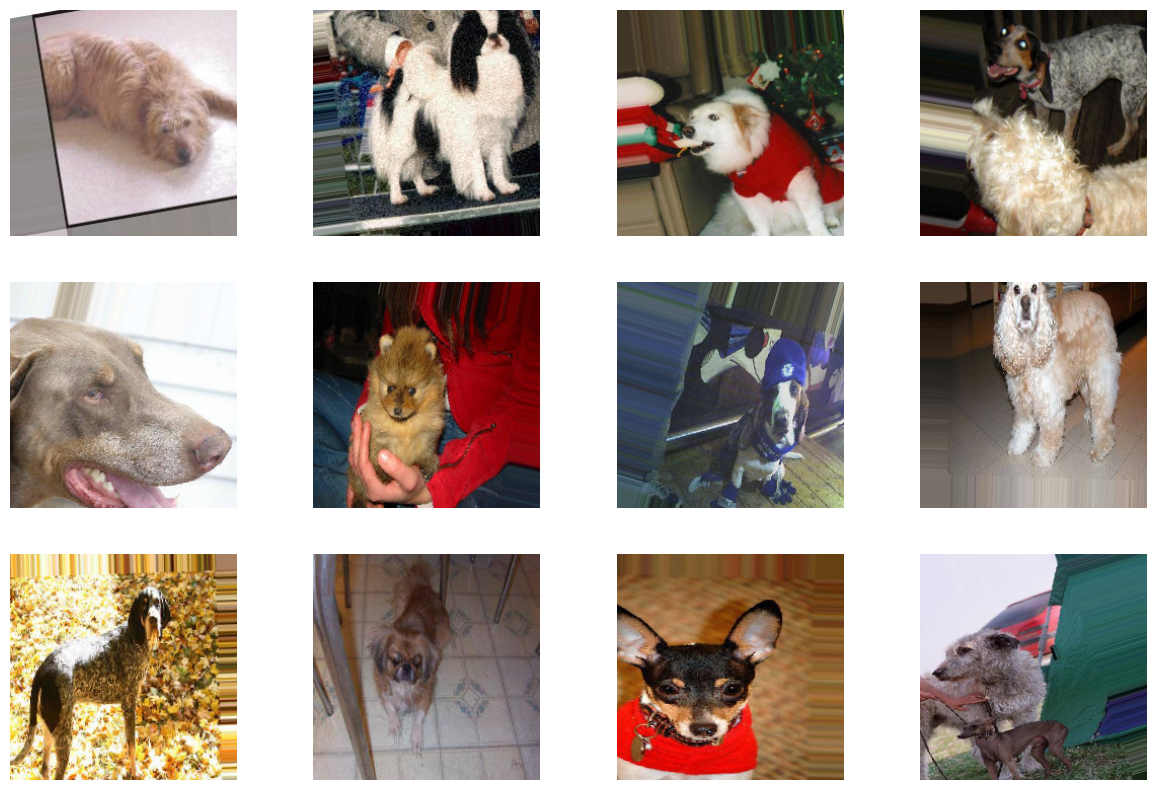

In [15]:
# 12 images after augmentation

img, label = next(train_generator)

fig = plt.figure(figsize=(15, 10))

for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')

In [16]:
# callbacks that will be used during training

checkpoint_path = 'weights.keras'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)

In [17]:
base_model = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

base_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activat

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
head_model = AveragePooling2D(pool_size=(4, 4))(base_model.output)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(1024, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(512, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(120, activation='softmax')(head_model)

In [20]:
model = Model(inputs=base_model.input, outputs=head_model)
optimizer = SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint = ModelCheckpoint(filepath='weights.keras', save_best_only=True)

# Now you can use the checkpoint callback during model training
history1 = model.fit(train_generator, epochs=5, validation_data=val_generator, callbacks=[checkpoint])

Epoch 1/5
256/256 [==============================] - 176s 678ms/step - loss: 4.4083 - accuracy: 0.2263 - val_loss: 4.6405 - val_accuracy: 0.0426
Epoch 2/5
256/256 [==============================] - 171s 666ms/step - loss: 4.8393 - accuracy: 0.0236 - val_loss: 4.7487 - val_accuracy: 0.0171
Epoch 3/5
256/256 [==============================] - 171s 669ms/step - loss: 4.7934 - accuracy: 0.0117 - val_loss: 4.7910 - val_accuracy: 0.0113
Epoch 4/5
256/256 [==============================] - 169s 661ms/step - loss: 4.7980 - accuracy: 0.0117 - val_loss: 4.7886 - val_accuracy: 0.0127
Epoch 5/5
256/256 [==============================] - 171s 668ms/step - loss: 4.7865 - accuracy: 0.0112 - val_loss: 4.7891 - val_accuracy: 0.0113


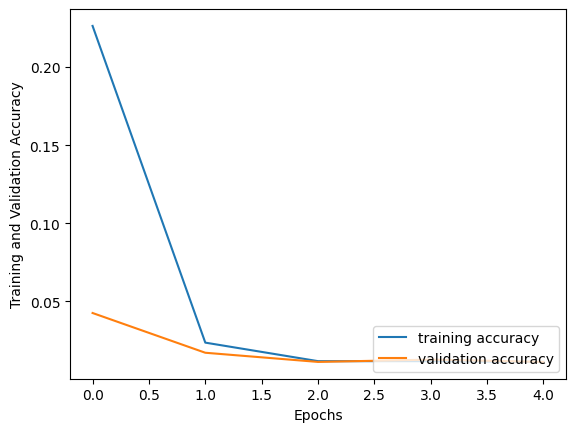

In [22]:
plt.plot(history1.history['accuracy'], label='training accuracy')
plt.plot(history1.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(loc='lower right')

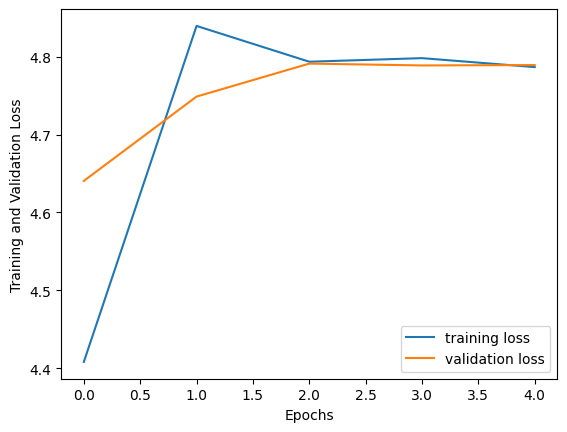

In [23]:
plt.plot(history1.history['loss'], label='training loss')
plt.plot(history1.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()

In [25]:
# loading the testset

test_images_files_names = os.listdir('/content/test')
test_set = pd.DataFrame(test_images_files_names, columns=['id'])
test_set.head()

,id
0,56c76aab35926ffe901a3ef9c78d4a28.jpg
1,25929fe1b00d59ad03db9576464e6cb9.jpg
2,c66cb0f979d1b1e1247ddd17f0471c04.jpg
3,a348eabfbbdc91423f1a8009f01fd16c.jpg
4,a9ee25d56bd8dbb5b7f340338901a879.jpg


In [39]:
test_data_generator = ImageDataGenerator(rescale= 1./255)
test_generator = test_data_generator.flow_from_dataframe(test_set, directory='/content/test', x_col='id',target_size=SIZE, class_mode=None, batch_size=BATCH_SIZE, shuffle=False)


Found 10357 validated image filenames.


In [27]:
model.load_weights('weights.keras')

In [28]:
y_prop = model.predict(test_generator)

324/324 [==============================] - 144s 442ms/step


In [29]:
results = pd.DataFrame(columns=["id"] + [*train_generator.class_indices.keys()])
results

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [30]:
results["id"] = [os.path.splitext(file)[0] for file in os.listdir('/content/test')]
results.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,56c76aab35926ffe901a3ef9c78d4a28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25929fe1b00d59ad03db9576464e6cb9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c66cb0f979d1b1e1247ddd17f0471c04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a348eabfbbdc91423f1a8009f01fd16c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,a9ee25d56bd8dbb5b7f340338901a879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
results[[*train_generator.class_indices.keys()]] = y_prop
results.head()

results.to_csv("results.csv",index=False)

In [33]:
model3 = load_model('/content/weights.keras')

In [45]:
# Assuming 'y_prop' contains the model's predicted probabilities
predicted_labels = np.argmax(y_prop, axis=1)

# Ensure that 'true_labels' is truncated or padded to match the length of 'predicted_labels'
min_length = min(len(true_labels), len(predicted_labels))
true_labels = true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f"Recall: {recall:.2f}")

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.01
Precision: 0.00
Recall: 0.01
F1 Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
